In [18]:
import numpy as np
import ruamel.yaml
import os
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Polygon
from IPython.display import clear_output
import torch
import sys
import pandas as pd
import os
import tarfile
import math
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


In [19]:
def calculate_power_with_wraparound(current, previous, time_diff, wraparound_value=262143.328850):
    diff = current - previous
    if diff < 0:  # Wraparound detected
        diff = (wraparound_value - previous) + current
    return diff / time_diff

def compute_power(pubEnergy):
    power = {}
    geopm_sensor0 = geopm_sensor1 = pd.DataFrame({'timestamp':[],'value':[]})
    for i,row in pubEnergy.iterrows():
        if i%2 == 0:
            geopm_sensor0 = pd.concat([geopm_sensor0, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)
        else:
            geopm_sensor1 = pd.concat([geopm_sensor1, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)


    power['geopm_power_0'] = pd.DataFrame({
        'timestamp': geopm_sensor0['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor0['value'][i],
                geopm_sensor0['value'][i-1],
                geopm_sensor0['timestamp'][i] - geopm_sensor0['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor0))
        ]
    })

    # Apply the same logic to geopm_power_1
    power['geopm_power_1'] = pd.DataFrame({
        'timestamp': geopm_sensor1['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor1['value'][i],
                geopm_sensor1['value'][i-1],
                geopm_sensor1['timestamp'][i] - geopm_sensor1['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor1))
        ]
    })

    min_length = min(len(power['geopm_power_0']), len(power['geopm_power_1']))
    geopm_power_0 = power['geopm_power_0'][:min_length]
    geopm_power_1 = power['geopm_power_1'][:min_length]

    average_power = pd.DataFrame({
        'timestamp': geopm_power_0['timestamp'],  # Use the timestamp from geopm_power_0
        'average_power': [(p0 + p1) / 2 for p0, p1 in zip(geopm_power_0['power'], geopm_power_1['power'])]
    })
    average_power['elapsed_time'] = average_power['timestamp'] - average_power['timestamp'].iloc[0]
    power['average_power'] = average_power
    return power

def measure_progress(progress_data, energy_data):
    Progress_DATA = {} 
    progress_sensor = pd.DataFrame(progress_data)
    first_sensor_point = min(energy_data['average_power']['timestamp'].iloc[0], progress_sensor['time'][0])
    progress_sensor['elapsed_time'] = progress_sensor['time'] - first_sensor_point  # New column for elapsed time
    # progress_sensor = progress_sensor.set_index('elapsed_time')
    performance_elapsed_time = progress_sensor.elapsed_time
    # Add performance_frequency as a new column in progress_sensor
    frequency_values = [
        progress_data['value'].iloc[t] / (performance_elapsed_time[t] - performance_elapsed_time[t-1]) for t in range(1, len(performance_elapsed_time))
    ]
    
    # Ensure the frequency_values length matches the index length
    frequency_values = [0] + frequency_values  # Prepend a 0 for the first index
    progress_sensor['frequency'] = frequency_values
    upsampled_timestamps= energy_data['average_power']['timestamp']
    
    # true_count = (progress_sensor['time'] <= upsampled_timestamps.iloc[0]).sum()

    progress_frequency_median = pd.DataFrame({'median': np.nanmedian(progress_sensor['frequency'].where(progress_sensor['time'] <= upsampled_timestamps.iloc[0])), 'timestamp': upsampled_timestamps.iloc[0]}, index=[0])
    for t in range(1, len(upsampled_timestamps)):
        progress_frequency_median = pd.concat([progress_frequency_median, pd.DataFrame({'median': [np.nanmedian(progress_sensor['frequency'].where((progress_sensor['time'] >= upsampled_timestamps.iloc[t-1]) & (progress_sensor['time'] <= upsampled_timestamps.iloc[t])))],
        'timestamp': [upsampled_timestamps.iloc[t]]})], ignore_index=True)
    progress_frequency_median['elapsed_time'] = progress_frequency_median['timestamp'] - progress_frequency_median['timestamp'].iloc[0]
    # Assign progress_frequency_median as a new column
    Progress_DATA['progress_sensor'] = progress_sensor
    Progress_DATA['progress_frequency_median'] = progress_frequency_median
    return Progress_DATA

def collect_papi(PAPI_data):
    PAPI = {}
    for scope in PAPI_data['scope'].unique():
        # Extract the string between the 3rd and 4th dots
        scope_parts = scope.split('.')
        if len(scope_parts) > 4:  # Ensure there are enough parts
            extracted_scope = scope_parts[3]
            # Aggregate the data for the extracted scope using pd.concat
            PAPI[extracted_scope] = PAPI_data[PAPI_data['scope'] == scope]
            instantaneous_values = [0] + [PAPI[extracted_scope]['value'].iloc[k] - PAPI[extracted_scope]['value'].iloc[k-1] for k in range(1,len(PAPI[extracted_scope]))]
            # Normalize the instantaneous values between 0 and 10
            min_val = min(instantaneous_values)
            max_val = max(instantaneous_values)
            PAPI[extracted_scope]['instantaneous_value'] = [(value - min_val) / (max_val - min_val) * 10 for value in instantaneous_values]
            PAPI[extracted_scope]['elapsed_time'] = PAPI[extracted_scope]['time'] - PAPI[extracted_scope]['time'].iloc[0]
    return PAPI

In [20]:
current_dir = os.getcwd()
DATA_DIR = os.path.join(current_dir, "experiment_data/data_generation")
root,folders,files = next(os.walk(DATA_DIR))
# print(root,folders,files)
training_data = {}
data = {}
for APP in folders:
    # fig, axs = plt.subplots(2,1,figsize=(12,10))
    # fig_PAPI, axs_PAPI = plt.subplots(5,1,figsize=(12,16))
    # print(APP)
    APP_DIR = os.path.join(DATA_DIR, APP)
    # print(APP_DIR)
    for file in next(os.walk(APP_DIR))[2]:
        # print(file)
        if file.endswith('.tar'):
            tar_path = os.path.join(APP_DIR, file)
            extract_dir = os.path.join(APP_DIR, file[:-4])  
            
            if not os.path.exists(extract_dir):
                os.makedirs(extract_dir)
            
            # Extract the tar file
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=extract_dir)
            
            # print(f"Extracted {file} to {extract_dir}")
        pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
        pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
        pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
        data['PCAP'] = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
        data['progress'] = measure_progress(pubProgress,pubEnergy)
        data['power'] = compute_power(pubEnergy)
        data['papi'] = collect_papi(pubPAPI)
        instant_1 = data['PCAP']['time'].iloc[0]
        for index, row in data['PCAP'].iterrows():
            if index > 0:  # Start from the second row
                print(index, row)
                instant_2 = row.time
                progress_data = data['progress']['progress_frequency_median'][(data['progress']['progress_frequency_median']['time'] > instant_1) & (data['progress']['progress_frequency_median']['time'] <= instant_2)]
                measured_power_data = data['power']['average_power'][(data['power']['average_power']['timestamp'] > instant_1) & (data['power']['average_power']['timestamp'] <= instant_2)]
                if not progress_data.empty:
                    avg_frequency = progress_data['frequency'].mean()
                    print(f"Average Progress Frequency: {avg_frequency}")
                
                if not measured_power_data.empty:
                    avg_power = measured_power_data['average_power'].mean()
                    print(f"Average Measured Power: {avg_power}")
                    
                
                instant_1 = instant_2
                
                # Placeholder for data['progress'] processing
                # You may want to add specific operations here

            
        # color = cm.tab10(len(data))  # Get a color from the colormap for each trace
        # axs[0].scatter(data['progress']['elapsed_time'], data['progress']['frequency'], label=file)  # Added label for legend
        # axs[1].scatter(data['power']['average_power']['elapsed_time'], data['power']['average_power']['average_power'], label=file)  # Added label for legend
        # axs[0].grid(True)
        # axs[1].grid(True)
        # axs[1].set_xlabel("Elapsed Time (s)")  # Changed to set_xlabel
        # axs[0].set_ylabel("Progress")  # Changed to set_ylabel
        # axs[1].set_ylabel("Power (W)")  # Changed to set_ylabel
        # axs[0].legend()  # Added legend for progress plot
        # axs[1].legend()  # Added legend for power plot
        # fig.suptitle(APP)

        # for i,scope in enumerate(data['papi'].keys()):
        #     axs_PAPI[i].scatter(data['papi'][scope]['elapsed_time'], data['papi'][scope]['instantaneous_value'], label=file)
        #     axs_PAPI[i].grid(True)
        #     axs_PAPI[i].set_ylabel(f"{scope} value")
        # axs_PAPI[i].set_xlabel("Elapsed Time (s)")
        # fig_PAPI.suptitle(APP)

# training_data_csv = pd.read_csv('./merged_data.csv')
# # PCAP = 0
# # CURRENT_PRO = 0
# # NEXT_PRO = 0
# training_dataset = []
# old_PCAP = 0
# action_set = []
# for index,row in training_data_csv.iterrows():
#     if not math.isnan(row['pcap']) and index < len(training_data_csv)-1:
#         s = row['median']
#         a = row['pcap']-ACTION_MIN
#         measured_power = (row['value0']+row['value1'])/2
#         new_PCAP = a
#         action_set.append(a)
#         s_prime = training_data_csv.loc[index+1]['median']
#         if math.isnan(s) or math.isnan(s_prime):
#             continue
#         elif new_PCAP != old_PCAP:
#             s = round(s)
#             s_prime = round(s_prime)
#             r = env.reward(s,a,s_prime,measured_power)
#             training_dataset.append((s, a, r, s_prime))
#         old_PCAP = new_PCAP
# print(training_dataset)


1 time                             1726168588.181641
actuator    Actuator(ptr=c_void_p(94258128757824))
value                                        159.0
Name: 1, dtype: object
Average Progress Frequency: 183.57852952332627
Average Measured Power: 148.3531166571113
2 time                             1726168593.196287
actuator    Actuator(ptr=c_void_p(94258128757824))
value                                        101.0
Name: 2, dtype: object
Average Progress Frequency: 186.11708705042975
Average Measured Power: 148.88482551467746
3 time                             1726168598.213152
actuator    Actuator(ptr=c_void_p(94258128757824))
value                                        124.0
Name: 3, dtype: object
Average Progress Frequency: 167.74418739835804
Average Measured Power: 109.31638006506896
4 time                             1726168603.229669
actuator    Actuator(ptr=c_void_p(94258128757824))
value                                        153.0
Name: 4, dtype: object
Average Progress Fr

In [4]:
T_S = 1
ACTIONS = [78.0, 83.0, 89.0, 95.0, 101.0, 107.0, 112.0, 118.0, 124.0, 130.0, 136.0, 141.0, 147.0, 153.0, 159.0, 165.0]
exec_steps = 10000    
TOTAL_ACTIONS = len(ACTIONS)                                                                                                  # Total clock cycles needed for the execution of program.
ACTION_MIN = ACTIONS[0]
ACTION_MAX = ACTIONS[-1]                                                                                                      # Maxima of control space
ACT_MID = ACTION_MIN + (ACTION_MAX - ACTION_MIN) / 2                                                                    # Midpoint of the control space to compute the normalized action space
OBS_MAX = 100                                                                                                           # Maxima of observation space (performance)
OBS_MIN = 0                                                                                                             # Minima of observation space
OBS_MID = OBS_MIN + (OBS_MAX - OBS_MIN) / 2
EXEC_ITERATIONS = 10000
TOTAL_ACTIONS = ACTION_MAX - ACTION_MIN
TOTAL_OBS = OBS_MAX - OBS_MIN

OBS_ONEHOT = 'onehot'
OBS_RANDOM = 'random'
OBS_SMOOTH = 'smooth'


class TransitionDynamics(object):
    def __init__(self,eps=0.2):
        self.eps = eps

    def get_aprobs(self,s,a):
        if a >= ACTION_MIN and a <= ACTION_MAX:
            legal_move = True
        else:
            legal_move = False
        p = np.ones(TOTAL_ACTIONS)*self.eps/(TOTAL_ACTIONS)
        if legal_move:
            p[a-ACTION_MIN] += 1.0-self.eps
        return p


def progress_funct(state, p_cap):
    p_now = state
    measured_power = A[cluster] * p_cap + B[cluster]
    pcap_old_L = -np.exp(-alpha[cluster] * (A[cluster] * p_cap + B[cluster] - beta[cluster]))                           # Calculation of the PCAP for fitting it into the model.
    progress_value = K_L[cluster] * T_S / (T_S + tau) * pcap_old_L + tau / (T_S + tau) * (p_now - K_L[cluster]) + \
                     K_L[cluster]                                                                                       # Mathematical relation
    progress_NL = K_L[cluster] * (1 + pcap_old_L)
    return_list = round(progress_value)
    return return_list,progress_NL,measured_power

class SYS(object):
    def __init__(self,PARAMS,iterations,observation_type=OBS_ONEHOT,dim_obs=1,teps=0.0):
        super(SYS,self).__init__()

        self.num_states = TOTAL_OBS
        self.num_actions = TOTAL_ACTIONS
        self.obs_type = observation_type
        # self.model = TransitionDynamics(eps=teps)
        # self._transition_matrix = None
        # self._transition_matrix = self.transition_matrix()
        self.current_step = 0

        if self.obs_type == OBS_RANDOM:
          self.dim_obs = dim_obs
          self.obs_matrix = np.random.randn(self.num_states, self.dim_obs)
        elif self.obs_type == OBS_SMOOTH:
          self.dim_obs = dim_obs
          self.obs_matrix = np.random.randn(self.num_states, self.dim_obs)
        #   trans_matrix = np.sum(self._transition_matrix, axis=1) / self.num_actions
        #   for k in range(10):
            # cur_obs_mat = self.obs_matrix[:,:]
            # for state in range(self.num_states):
                # new_obs = trans_matrix[state].dot(cur_obs_mat)
                # self.obs_matrix[state] = new_obs
        # else:
        #   self.dim_obs = self.gs.width+self.gs.height


    def observation(self, s):
        if self.obs_type == OBS_ONEHOT:
          xy_vec = np.zeros(self.gs.width+self.gs.height)
          xy = self.gs.idx_to_xy(s)
          xy_vec[xy[0]] = 1.0
          xy_vec[xy[1]+self.gs.width] = 1.0
          return xy_vec
        elif self.obs_type == OBS_RANDOM or self.obs_type == OBS_SMOOTH:
          return self.obs_matrix[s]
        else:
          raise ValueError("Invalid obs type %s" % self.obs_type)
    
    def reward(self, s, a, ns, measured_power):
        """ 
        Returns the reward (float)
        """
        # measured_power = A[cluster] * a + B[cluster]
        if ns > 0:
            # self.current_step += ns
            # reward = - 5*a
            # reward = 2*ns/(((a)/measured_power)+measured_power) # Check the behaviour across the states
            reward = -ns/(2*a**2+1)
            # reward = 5*a
        else:
            reward = -100
        # print(reward)
        return reward

    

In [5]:
weighting_only = False
dataset_composition = 'random'
dataset_size = 1000
env_type = 'random'
PARAMS = 'ones-stream-full'
env = SYS(PARAMS,EXEC_ITERATIONS,observation_type=env_type, dim_obs=8, teps=0)


[(42, 80.0, -0.0031247558784469965, 40), (46, 73.0, -0.0041279669762641896, 44), (44, 42.0, -0.003967129498441485, 14), (10, 51.0, -0.00768787238131847, 40), (39, 21.0, -0.026047565118912798, 23), (26, 43.0, -0.005406866720735334, 20), (20, 14.0, -0.04834605597964377, 19), (8, 65.0, -0.004969826056088037, 42), (43, 52.0, -0.007210205213533, 39), (40, 59.0, -0.0061754990664943275, 43), (43, 1.0, -1.3333333333333333, 4), (5, 3.0, -0.42105263157894735, 8), (6, 21.0, -0.009060022650056626, 8), (25, 60.0, -0.005832523260658242, 42), (42, 46.0, -0.008268367587999054, 35), (32, 35.0, -0.0138718890248878, 34), (30, 19.0, -0.030428769017980636, 22), (25, 39.0, -0.0111731843575419, 34), (33, 60.0, -0.005832523260658242, 42), (42, 78.0, -0.003615744925630701, 44), (43, 43.0, -0.009462016761286834, 35), (33, 42.0, -0.009917823746103713, 35), (33, 73.0, -0.0041279669762641896, 44), (45, 72.0, -0.004243417880219886, 44), (42, 10.0, -0.07462686567164178, 15), (15, 44.0, -0.008520526723470178, 33), (3

In [7]:
#@ Plotting tools

PLT_NOOP = np.array([[-0.1,0.1], [-0.1,-0.1], [0.1,-0.1], [0.1,0.1]])
PLT_UP = np.array([[0,0], [0.5,0.5], [-0.5,0.5]])
PLT_LEFT = np.array([[0,0], [-0.5,0.5], [-0.5,-0.5]])
PLT_RIGHT = np.array([[0,0], [0.5,0.5], [0.5,-0.5]])
PLT_DOWN = np.array([[0,0], [0.5,-0.5], [-0.5,-0.5]])

TXT_OFFSET_VAL = 0.3
TXT_CENTERING = np.array([-0.08, -0.05])
TXT_NOOP = np.array([0.0,0])+TXT_CENTERING
TXT_UP = np.array([0,TXT_OFFSET_VAL])+TXT_CENTERING
TXT_LEFT = np.array([-TXT_OFFSET_VAL,0])+TXT_CENTERING
TXT_RIGHT = np.array([TXT_OFFSET_VAL,0])+TXT_CENTERING
TXT_DOWN = np.array([0,-TXT_OFFSET_VAL])+TXT_CENTERING



ACT_OFFSETS = [[i,TXT_NOOP] for i in range(0,TOTAL_ACTIONS)]

PLOT_CMAP = cm.RdYlBu

def plot_sa_values(env, q_values, text_values=True, 
                   invert_y=True, update=False,
                   title=None):
  w = TOTAL_OBS
  h = TOTAL_ACTIONS
  
  if update:
    clear_output(wait=True)
  plt.figure(figsize=(2*w, 2*h))
  ax = plt.gca()
  normalized_values = q_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  for x, y in itertools.product(range(w), range(h)):
    #   state_idx = env.gs.xy_to_idx((x, y))
    #   if invert_y:
        #   y = h-y-1
      xy = np.array([x, y])
      xy3 = np.expand_dims(xy, axis=0)
      state_idx = x
    #   print(x)

      for a in range(ACTION_MAX-1,ACTION_MIN,-1):
          a = a - ACTION_MIN
        #   print(a)
          val = normalized_values[state_idx,a]
          og_val = q_values[state_idx,a]
          patch_offset, txt_offset = ACT_OFFSETS[a]
          if text_values:
              xy_text = xy+txt_offset
              ax.text(xy_text[0], xy_text[1], '%.2f'%og_val, size='small')
          color = PLOT_CMAP(val)
          ax.add_patch(Polygon(xy3+patch_offset, True,
                                     color=color))
  ax.set_xticks(np.arange(-1, w+1, 1))
  ax.set_yticks(np.arange(-1, h+1, 1))
  plt.grid()
  if title:
    plt.title(title)
  # plt.draw()
  # frame_number+=1
  plt.savefig(f'{title}.png')
  frame_number += 1
  # plt.close()

def plot_sa_values_simple(env, q_values, text_values=True, 
                   invert_y=True, update=False,
                   title=None):
  w = TOTAL_OBS
  h = TOTAL_ACTIONS
  
  # plt.figure(figsize=(2*w, 2*h))
  # ax = plt.gca()
  normalized_values = q_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  
  img = plt.imshow(normalized_values, cmap=PLOT_CMAP, interpolation='nearest', aspect='auto')
  ax = plt.gca()
  for x, y in itertools.product(range(h), range(w)):
      # a = x + ACTION_MIN
      # val = normalized_values[x,y]
      og_val = q_values[y,x]
      # print(og_val)
      _, txt_offset = TXT_NOOP
      if text_values:
          xy_text = np.array([x, y])+txt_offset
          # print(xy_text,np.array([x,y]))
          ax.text(xy_text[0], xy_text[1], '%.2f'%og_val, fontsize=2)
  ax.set_xticks(np.arange(-1, h+1, 1))
  ax.set_yticks(np.arange(-1, w+1, 1))
  plt.grid()
  if title:
    plt.title(title)
  # plt.draw()
  # frame_number+=1
  plt.savefig(f'{title}.png')
  # frame_number += 1
  # plt.close()  

def plot_s_values(env, v_values, text_values=True, 
                  invert_y=True, update=False,
                  title=None):
  w = TOTAL_OBS
  h = TOTAL_OBS
  if update:
    clear_output(wait=True)
  plt.figure(figsize=(2*w, 2*h))
  ax = plt.gca()
  normalized_values = v_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  for x, y in itertools.product(range(w), range(h)):
      state_idx = x

      xy = np.array([x, y])

      val = normalized_values[state_idx]
      og_val = v_values[state_idx]
      if text_values:
          xy_text = xy
          ax.text(xy_text[0], xy_text[1], '%.2f'%og_val, size='small')
      color = PLOT_CMAP(val)
      ax.add_patch(Rectangle(xy-0.5, 1, 1, color=color))
  ax.set_xticks(np.arange(-1, w+1, 1))
  ax.set_yticks(np.arange(-1, h+1, 1))
  plt.grid()  
  if title:
    plt.title(title)
  plt.draw()
  plt.savefig(f'frame_{frame_number}.png')
  # plt.close()
# print(training_dataset)
  
def plot_test_actions(env, q_values, text_values=True, 
                   invert_y=True, update=False,
                   title=None):
  h = TOTAL_OBS
  w = TOTAL_ACTIONS          # ax.add_patch(Polygon(xy3+patch_offset, True,
          #                            color=color))
  
  if update:
    clear_output(wait=True)
  # plt.figure(figsize=(2*w, 2*h))
  # ax1 = plt.gca()
  # plt.figure(figsize=(2*w, 2*h))
  # ax2 = plt.gca()
  fig1,ax1 = plt.subplots()
  fig2,ax2 = plt.subplots()
  normalized_values = q_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  # for x, y in itertools.product(range(w), range(h)):
    #   state_idx = env.gs.xy_to_idx((x, y))
    #   if invert_y:
        #   y = h-y-1
      # xy = np.array([x, y])
      # xy3 = np.expand_dims(xy, axis=0)
      # state_idx = x
    #   print(x)
  complete = False
  new_s = 0
  count = 0
  RUNTIME = 100
  PROGRESS = []
  PCAP = []
  TIME = []
  while not complete:
      state_idx = new_s
      # for a in range(ACTION_MAX-1,ACTION_MIN,-1):
          # a = a - ACTION_MIN
        #   print(a)
      # val = normalized_values[state_idx,a]
      og_act = np.max(q_values[state_idx,:])
      act = np.argmax(q_values[state_idx,:])+ACTION_MIN
      new_s,_,MP = progress_funct(state_idx,act)
      PROGRESS.append(new_s)
      PCAP.append(act)
      TIME.append(count)
      # ax1.plot(state_idx,act,'r--')
      # ax2.plot(MP,act,'k.')
      # print(count)
      if count == RUNTIME:
         complete = True
      count += 1
  ax1.scatter(TIME,PCAP,marker='.', color='k', s=30, label=f'{"PCAP"}')
  ax1.grid(True)
  ax1.set_ylabel('PCAP',fontsize = 15)
  ax1.set_xlabel('time [s]', fontsize = 15)
  ax1.tick_params(axis='x', labelsize=8)
  ax1.tick_params(axis='y', labelsize=8)
  ax1.legend(fontsize = 13)
  title1 = f"{cluster}"
  ax1.set_title(title1, fontsize=15, color = 'blue')
  fig1.savefig(f'PCAP_{title}.png')

  ax2.scatter(TIME,PROGRESS,marker='.', color='r', s=30, label=f'{"PROGRESS"}')
  ax2.grid(True)
  ax2.set_ylabel('PROGRESS',fontsize = 15)
  ax2.set_xlabel('time [s]', fontsize = 15)
  ax2.tick_params(axis='x', labelsize=8)
  ax2.tick_params(axis='y', labelsize=8)
  ax2.legend(fontsize = 13)
  title1 = f"{cluster}"
  ax2.set_title(title1, fontsize=15, color = 'blue')
  fig2.savefig(f'progress_{title}.png')

  print(f"Total energy consumed is {sum(PCAP)} kJ")



In [8]:
def get_tensors(list_of_tensors, list_of_indices):
  s, a, ns, r = [], [], [], []
  for idx in list_of_indices:
    s.append(list_of_tensors[idx][0])
    a.append(list_of_tensors[idx][1])
    r.append(list_of_tensors[idx][2])
    ns.append(list_of_tensors[idx][3])
  s = np.array(s)
  a = np.array(a)
  ns = np.array(ns)
  r = np.array(r)
  return s, a, ns, r

In [9]:
#@ NN definition for fitted Q learning

def stack_observations(env):
    obs = []
    for s in range(env.num_states):
        obs.append(env.observation(s))
    return np.stack(obs)

class FCNetwork(torch.nn.Module):
  def __init__(self, env, layers=[20,20]):
    super(FCNetwork, self).__init__()
    self.all_observations = torch.tensor(stack_observations(env), dtype=torch.float32)
    dim_input = env.dim_obs
    dim_output = env.num_actions
    net_layers = []

    dim = dim_input
    for i, layer_size in enumerate(layers):
      net_layers.append(torch.nn.Linear(dim, layer_size))
      net_layers.append(torch.nn.ReLU())
      dim = layer_size
    net_layers.append(torch.nn.Linear(dim, dim_output))
    self.layers = net_layers
    self.network = torch.nn.Sequential(*net_layers)

  def forward(self, states):
    observations = torch.index_select(self.all_observations, 0, states)
    return self.network(observations)


In [10]:
#@ Fitted Q learning

def q_backup_sparse(env, q_values, discount=0.99):
  dS = env.num_states
  dA = env.num_actions

  new_q_values = np.zeros_like(q_values)
  value = np.max(q_values, axis=1)
  for s in range(dS):
    for a in range(dA):
      new_q_value = 0
      for ns, prob in env.transitions(s, a).items():
        new_q_value += prob * (env.reward(s,a,ns) + discount*value[ns])
      new_q_values[s,a] = new_q_value
  return new_q_values

def q_backup_sparse_sampled(env, q_values, s, a, ns, r, discount=0.99):
  q_values_ns = q_values[ns, :]
  values = np.max(q_values_ns, axis=-1)
  target_value = r + discount * values
  return target_value

def project_qvalues(q_values, network, optimizer, num_steps=50, weights=None):
    # regress onto q_values (aka projection)
    q_values_tensor = torch.tensor(q_values, dtype=torch.float32)
    for _ in range(num_steps):
       # Eval the network at each state
      pred_qvalues = network(torch.arange(q_values.shape[0]))
      if weights is None:
        loss = torch.mean((pred_qvalues - q_values_tensor)**2)
      else:
        loss = torch.mean(weights*(pred_qvalues - q_values_tensor)**2)
      network.zero_grad()
      loss.backward()
      optimizer.step()
    return pred_qvalues.detach().numpy()

def project_qvalues_sampled(env, s, a, target_values, network, optimizer, num_steps=50, weights=None):
    # train with a sampled dataset
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    a = torch.tensor(a, dtype=torch.int64)
    pred_qvalues = network(s)
    pred_qvalues = pred_qvalues.gather(1, a.reshape(-1,1)).squeeze()
    loss = torch.mean((pred_qvalues - target_qvalues)**2)
    network.zero_grad()
    loss.backward()
    optimizer.step()

    pred_qvalues = network(torch.arange(env.num_states))
    return pred_qvalues.detach().numpy()

def fitted_q_iteration(env,
                       network,
                       num_itrs=100,
                       project_steps=100,
                       render=False,
                       weights=None,
                       sampled=False,
                       training_dataset=None,
                       **kwargs):
  """
  Runs Fitted Q-iteration.

  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions

  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  weights_tensor = None
  if weights is not None:
    weights_tensor = torch.tensor(weights, dtype=torch.float32)

  q_values = np.zeros((dS, dA))
  for i in range(num_itrs):
    if sampled:
      for j in range(project_steps):
        # print(f"---{i},{j}")
        training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
        s, a, ns, r = get_tensors(training_dataset, training_idx)
        target_values = q_backup_sparse_sampled(env, q_values, s, a, ns, r, **kwargs)
        intermed_values = project_qvalues_sampled(
            env, s, a, target_values, network, optimizer, weights=None,
        )
        if j == project_steps - 1:
          q_values = intermed_values
    else:
      target_values = q_backup_sparse(env, q_values, **kwargs)
      q_values = project_qvalues(target_values, network, optimizer,
                                weights=weights_tensor,
                                num_steps=project_steps)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  return q_values

In [11]:

network = FCNetwork(env, layers=[20, 20])

ONN_q_values = fitted_q_iteration(env, network,
                              num_itrs=10000, discount=0.95,
                              weights=None, render=False,
                              sampled=not(weighting_only),
                              training_dataset=training_dataset)


[[38005.55  38922.1   38444.973 ... 38722.457 38445.137 37779.582]
 [38776.21  37495.902 37846.887 ... 37987.766 37344.914 36704.04 ]
 [38756.383 39583.94  39401.92  ... 39180.48  39237.496 39341.383]
 ...
 [38492.66  39366.793 39054.85  ... 38331.242 38536.5   39074.523]
 [38461.68  40015.895 39485.26  ... 39136.266 39476.453 39398.62 ]
 [39549.742 39788.58  39179.664 ... 39679.44  39524.207 38254.01 ]]
Total energy consumed is 6144 kJ


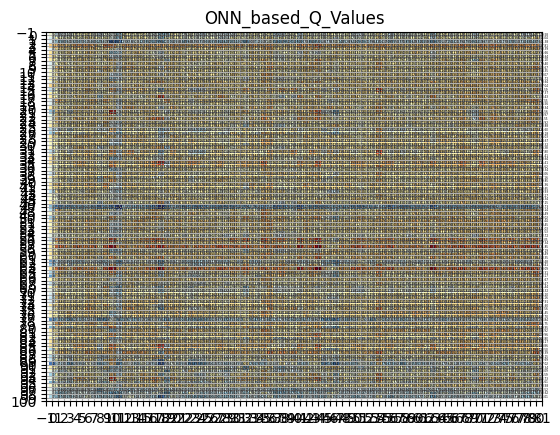

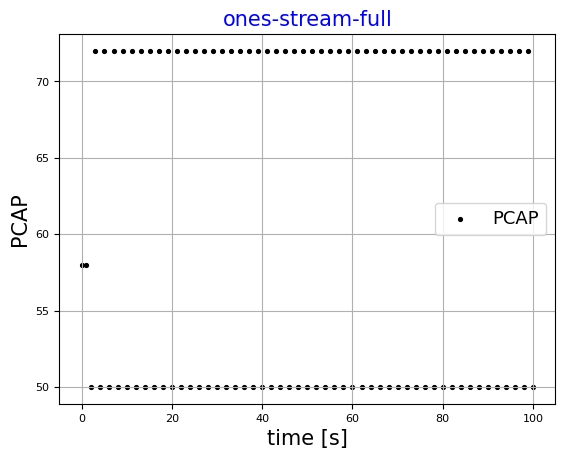

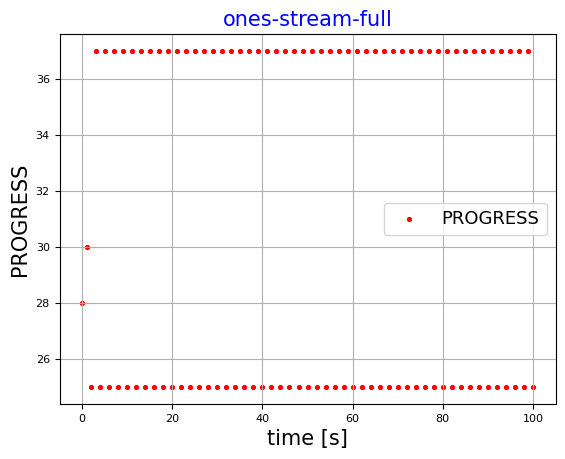

In [ ]:
print(ONN_q_values)
np.savetxt('Q_matrix_export.csv', ONN_q_values, delimiter=',', fmt='%.4f')

plot_sa_values_simple(env, ONN_q_values, update=True, title='ONN_based_Q_Values')

plot_test_actions(env,ONN_q_values, title='ONN_based_execution_plot')


In [ ]:
Q_MATRIX = np.loadtxt('Q_matrix_export.csv', delimiter=',')
